# Actor-Critic con Aproximadores de Función de Valor
## Laboratorio 8 - Aprendizaje por Refuerzo
### Descripción
Implementación de algoritmo Actor-Critic comparando diferentes aproximadores de función de valor, incluyendo la adaptación de un modelo ganador previo como Critic.


In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import seaborn as sns
from IPython.display import clear_output
import time

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

### Entorno
- **Entorno**: CartPole-v1 (Gymnasium)
- **Estado**: Vector continuo de 4 variables (posición, velocidad, ángulo, velocidad angular)
- **Acciones**: Discretas (izquierda/derecha)
- **Objetivo**: Mantener el palo equilibrado el mayor tiempo posible

In [2]:
env_name = "CartPole-v1"
env = gym.make(env_name)
eval_env = gym.make(env_name)

### Arquitecturas Implementadas

#### 1. BestPerformingCritic
- **Origen**: Modelo ganador del laboratorio anterior adaptado
- **Arquitectura**: 128 → 128 → 64 → 1
- **Función**: Aproximador V(s) adaptado de Q(s,a)
- **Learning Rate**: 0.001

In [3]:
class ModeloAnteriorCritico(nn.Module):
    """
    Critic basado en tu mejor modelo del laboratorio anterior
    Adaptado de Q-learning a Value Function estimation
    """
    def __init__(self, state_dim):
        super(ModeloAnteriorCritico, self).__init__()
        # Arquitectura exacta de tu mejor modelo
        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Cambiado de action_dim a 1 para V(s)
        )

        # Aplicar inicialización similar a tu modelo original
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.network(x).squeeze(-1)

#### 2. StandardCritic
- **Arquitectura**: 128 → 128 → 64 → 1
- **Configuración**: Estándar Actor-Critic
- **Learning Rate**: 3e-4

In [4]:
class StandardActor(nn.Module):
    """
    Actor estándar para mantener simplicidad en la política
    """
    def __init__(self, n_inputs, n_outputs, hidden_size=128, dropout_rate=0.0):
        super(StandardActor, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(n_inputs, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, n_outputs)
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        logits = self.network(x)
        return Categorical(logits=logits)

In [5]:
class StandardCritic(nn.Module):
    """
    Critic estándar para comparación
    """
    def __init__(self, n_inputs, hidden_size=128, dropout_rate=0.0, activation='relu'):
        super(StandardCritic, self).__init__()

        if activation == 'relu':
            act_fn = nn.ReLU()
        elif activation == 'tanh':
            act_fn = nn.Tanh()
        elif activation == 'elu':
            act_fn = nn.ELU()
        else:
            act_fn = nn.ReLU()

        self.network = nn.Sequential(
            nn.Linear(n_inputs, hidden_size),
            act_fn,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size),
            act_fn,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size // 2),
            act_fn,
            nn.Linear(hidden_size // 2, 1)
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.network(x).squeeze(-1)

In [6]:
class ActorCritic(nn.Module):
    """
    Arquitectura Actor-Critic usando tu mejor modelo como Critic
    """
    def __init__(self, n_inputs, n_outputs, hidden_size=128, dropout_rate=0.0,
                 activation='relu', use_best_critic=True):
        super(ActorCritic, self).__init__()

        self.use_best_critic = use_best_critic

        # Seleccionar tipo de Critic
        if use_best_critic:
            self.critic = ModeloAnteriorCritico(n_inputs)
            print("Usando arquitectura del mejor modelo del laboratorio anterior como Critic")
        else:
            self.critic = StandardCritic(n_inputs, hidden_size, dropout_rate, activation)
            print("Usando Critic estándar")

        # Actor estándar
        self.actor = StandardActor(n_inputs, n_outputs, hidden_size, dropout_rate)

    def forward(self, x):
        value = self.critic(x)
        dist = self.actor(x)
        return dist, value

In [7]:
class ObsNorm:
    """Normalización de observaciones mejorada con estabilidad numérica"""
    def __init__(self, eps=1e-8):
        self.count = 0
        self.mean = None
        self.var = None
        self.eps = eps
        self.momentum = 0.99

    def update(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        x = x.flatten()

        if self.mean is None:
            self.mean = x.clone()
            self.var = torch.ones_like(x)
            self.count = 1
            return

        self.count += 1
        delta = x - self.mean
        self.mean = self.momentum * self.mean + (1 - self.momentum) * x
        self.var = self.momentum * self.var + (1 - self.momentum) * delta * delta

    def normalize(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        x = x.flatten()

        if self.mean is None:
            return x

        std = torch.sqrt(self.var + self.eps)
        return (x - self.mean) / std

In [8]:
def compute_returns_gae(next_value, rewards, masks, values, gamma=0.99, lam=0.95):
    """Generalized Advantage Estimation (GAE)"""
    T = len(rewards)
    returns = torch.zeros(T, dtype=torch.float32)
    advantages = torch.zeros(T, dtype=torch.float32)

    gae = 0.0
    for t in reversed(range(T)):
        v_next = next_value if t == T-1 else values[t+1]
        delta = rewards[t] + gamma * v_next * masks[t] - values[t]
        gae = delta + gamma * lam * masks[t] * gae
        advantages[t] = gae
        returns[t] = advantages[t] + values[t]

    return returns, advantages

In [9]:
def test_env(model, n_episodes=5, max_steps=500):
    """Evaluación determinística del modelo"""
    total_rewards = []
    obs_norm_eval = ObsNorm()

    for episode in range(n_episodes):
        state, _ = eval_env.reset()
        obs_norm_eval.update(state)
        state = obs_norm_eval.normalize(state)

        episode_reward = 0
        steps = 0
        done = False

        while not done and steps < max_steps:
            state_t = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                dist, _ = model(state_t)
                action = dist.probs.argmax(dim=-1)

            next_state, reward, terminated, truncated, _ = eval_env.step(int(action))
            obs_norm_eval.update(next_state)
            next_state = obs_norm_eval.normalize(next_state)

            done = terminated or truncated
            state = next_state
            episode_reward += reward
            steps += 1

        total_rewards.append(episode_reward)

    return np.mean(total_rewards), np.std(total_rewards)

In [10]:
def ema(values, alpha=0.1):
    """Exponential Moving Average para suavizar gráficos"""
    if len(values) == 0:
        return []
    smoothed = [values[0]]
    for i in range(1, len(values)):
        smoothed.append(alpha * values[i] + (1 - alpha) * smoothed[-1])
    return smoothed

In [11]:
class MetricsTracker:
    """Clase para rastrear y visualizar métricas"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.frames = []
        self.actor_losses = []
        self.critic_losses = []
        self.total_losses = []
        self.entropies = []
        self.eval_rewards_mean = []
        self.eval_rewards_std = []
        self.episode_rewards = []
        self.episode_lengths = []

    def update(self, frame, actor_loss, critic_loss, total_loss, entropy):
        self.frames.append(frame)
        self.actor_losses.append(actor_loss)
        self.critic_losses.append(critic_loss)
        self.total_losses.append(total_loss)
        self.entropies.append(entropy)

    def add_eval(self, reward_mean, reward_std):
        self.eval_rewards_mean.append(reward_mean)
        self.eval_rewards_std.append(reward_std)

    def plot_training_progress(self, use_ema=True, alpha=0.1):
        """Visualización completa del progreso de entrenamiento"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Progreso del Entrenamiento Actor-Critic', fontsize=16)

        # Pérdidas
        ax1 = axes[0, 0]
        if use_ema:
            ax1.plot(self.frames, ema(self.actor_losses, alpha), label='Actor Loss (EMA)', color='blue')
            ax1.plot(self.frames, ema(self.critic_losses, alpha), label='Critic Loss (EMA)', color='red')
            ax1.plot(self.frames, ema(self.total_losses, alpha), label='Total Loss (EMA)', color='green')
        else:
            ax1.plot(self.frames, self.actor_losses, label='Actor Loss', alpha=0.7, color='blue')
            ax1.plot(self.frames, self.critic_losses, label='Critic Loss', alpha=0.7, color='red')
            ax1.plot(self.frames, self.total_losses, label='Total Loss', alpha=0.7, color='green')
        ax1.set_xlabel('Frames')
        ax1.set_ylabel('Loss')
        ax1.set_title('Evolución de Pérdidas')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Entropía
        ax2 = axes[0, 1]
        entropy_plot = ema(self.entropies, alpha) if use_ema else self.entropies
        ax2.plot(self.frames, entropy_plot, label='Entropy', color='purple')
        ax2.set_xlabel('Frames')
        ax2.set_ylabel('Entropy')
        ax2.set_title('Exploración (Entropía)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Recompensas de evaluación
        ax3 = axes[1, 0]
        eval_frames = [f for f in self.frames if f % 1000 == 0]
        if len(self.eval_rewards_mean) > 0:
            ax3.plot(eval_frames, self.eval_rewards_mean, 'o-', label='Reward Mean', color='orange')
            ax3.fill_between(eval_frames,
                           np.array(self.eval_rewards_mean) - np.array(self.eval_rewards_std),
                           np.array(self.eval_rewards_mean) + np.array(self.eval_rewards_std),
                           alpha=0.3, color='orange')
        ax3.set_xlabel('Frames')
        ax3.set_ylabel('Reward')
        ax3.set_title('Rendimiento en Evaluación')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # Distribución de recompensas recientes
        ax4 = axes[1, 1]
        if len(self.eval_rewards_mean) > 10:
            recent_rewards = self.eval_rewards_mean[-10:]
            ax4.hist(recent_rewards, bins=10, alpha=0.7, color='green', edgecolor='black')
            ax4.axvline(np.mean(recent_rewards), color='red', linestyle='--',
                       label=f'Media: {np.mean(recent_rewards):.1f}')
        ax4.set_xlabel('Reward')
        ax4.set_ylabel('Frecuencia')
        ax4.set_title('Distribución de Recompensas (Últimos 10 eval)')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

In [12]:
def train_actor_critic(config):
    """Función principal de entrenamiento con configuración flexible"""
    # Configuración por defecto
    default_config = {
        'hidden_size': 128,
        'lr': 3e-4,
        'n_steps': 50,
        'max_frames': 100000,
        'gamma': 0.99,
        'lam': 0.95,
        'entropy_coef': 0.01,
        'value_loss_coef': 0.5,
        'max_grad_norm': 0.5,
        'dropout_rate': 0.0,
        'activation': 'relu',
        'critic_loss_type': 'mse',
        'use_best_critic': True,
    }

    # Actualizar configuración
    for key, value in config.items():
        default_config[key] = value
    config = default_config

    print(f"Entrenando con configuración: {config}")

    # Inicialización
    n_inputs = env.observation_space.shape[0]
    n_outputs = env.action_space.n

    model = ActorCritic(n_inputs, n_outputs, config['hidden_size'],
                       config['dropout_rate'], config['activation'],
                       config['use_best_critic'])

    # Learning rate diferenciado para tu modelo
    if config['use_best_critic']:
        critic_params = list(model.critic.parameters())
        actor_params = list(model.actor.parameters())

        optimizer = optim.Adam([
            {'params': actor_params, 'lr': config['lr']},
            {'params': critic_params, 'lr': 0.001}  # LR de tu modelo original
        ])
        print("Usando learning rate diferenciado: Actor=3e-4, Critic=1e-3")
    else:
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])

    obs_norm = ObsNorm()
    metrics = MetricsTracker()

    # Estado inicial
    state, _ = env.reset()
    obs_norm.update(state)
    state = obs_norm.normalize(state)

    frame_idx = 0
    episode_reward = 0
    episode_length = 0

    print("Iniciando entrenamiento...")

    while frame_idx < config['max_frames']:
        log_probs = []
        values = []
        rewards = []
        masks = []
        entropy_sum = 0.0

        # Recolección de datos
        for step in range(config['n_steps']):
            state_t = torch.as_tensor(state, dtype=torch.float32)
            dist, value = model(state_t)

            action = dist.sample()
            next_state, reward, terminated, truncated, _ = env.step(int(action.item()))

            obs_norm.update(next_state)
            next_state = obs_norm.normalize(next_state)
            done = terminated or truncated

            log_prob = dist.log_prob(action)
            entropy_sum += dist.entropy()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.tensor(reward, dtype=torch.float32))
            masks.append(torch.tensor(1.0 - float(done), dtype=torch.float32))

            episode_reward += reward
            episode_length += 1

            if done:
                metrics.episode_rewards.append(episode_reward)
                metrics.episode_lengths.append(episode_length)
                episode_reward = 0
                episode_length = 0
                state, _ = env.reset()
                obs_norm.update(state)
                state = obs_norm.normalize(state)
            else:
                state = next_state

            frame_idx += 1

            # Evaluación periódica
            if frame_idx % 1000 == 0:
                reward_mean, reward_std = test_env(model)
                metrics.add_eval(reward_mean, reward_std)
                critic_type = "Best Model" if config['use_best_critic'] else "Standard"
                print(f"Frame {frame_idx}: Reward = {reward_mean:.2f} ± {reward_std:.2f} | Critic: {critic_type}")

        # Cálculo de returns y ventajas
        next_state_t = torch.as_tensor(state, dtype=torch.float32)
        with torch.no_grad():
            _, next_value = model(next_state_t)

        returns, advantages = compute_returns_gae(
            next_value, rewards, masks, values, config['gamma'], config['lam']
        )

        # Preparación para el cálculo de pérdidas
        log_probs = torch.stack(log_probs)
        values = torch.stack(values)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Cálculo de pérdidas
        actor_loss = -(log_probs * advantages.detach()).mean()

        if config['critic_loss_type'] == 'mse':
            critic_loss = F.mse_loss(values, returns)
        elif config['critic_loss_type'] == 'smooth_l1':
            critic_loss = F.smooth_l1_loss(values, returns)
        elif config['critic_loss_type'] == 'huber':
            critic_loss = F.huber_loss(values, returns)
        else:
            critic_loss = F.mse_loss(values, returns)

        entropy_loss = entropy_sum / len(log_probs)
        total_loss = (actor_loss +
                     config['value_loss_coef'] * critic_loss -
                     config['entropy_coef'] * entropy_loss)

        # Actualización
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config['max_grad_norm'])
        optimizer.step()

        # Registro de métricas
        metrics.update(frame_idx, actor_loss.item(), critic_loss.item(),
                      total_loss.item(), entropy_loss.item())

        # Visualización periódica
        if frame_idx % 5000 == 0:
            clear_output(wait=True)
            metrics.plot_training_progress(use_ema=True, alpha=0.1)

    print("Entrenamiento completado!")
    return model, metrics

### Configuraciones Experimentales

In [13]:
configs = {
    'best_critic_baseline': {
        'hidden_size': 128,
        'lr': 3e-4,
        'entropy_coef': 0.01,
        'critic_loss_type': 'mse',
        'use_best_critic': True
    },
    'best_critic_smooth_l1': {
        'hidden_size': 128,
        'lr': 3e-4,
        'entropy_coef': 0.01,
        'critic_loss_type': 'smooth_l1',
        'use_best_critic': True
    },
    'best_critic_huber': {
        'hidden_size': 128,
        'lr': 3e-4,
        'entropy_coef': 0.01,
        'critic_loss_type': 'huber',
        'use_best_critic': True
    },
    'standard_critic_baseline': {
        'hidden_size': 128,
        'lr': 3e-4,
        'entropy_coef': 0.01,
        'critic_loss_type': 'mse',
        'use_best_critic': False
    },
    'best_critic_high_entropy': {
        'hidden_size': 128,
        'lr': 3e-4,
        'entropy_coef': 0.05,
        'critic_loss_type': 'mse',
        'use_best_critic': True
    }
}

In [14]:
results = {}

In [15]:
for name, config in configs.items():
    print(f"\n{'='*60}")
    critic_type = "TU MEJOR MODELO" if config.get('use_best_critic', False) else "Standard Critic"
    print(f"Entrenando: {name} | Critic: {critic_type}")
    print(f"{'='*60}")

    model, metrics = train_actor_critic(config)
    results[name] = {
        'model': model,
        'metrics': metrics,
        'final_performance': metrics.eval_rewards_mean[-1] if metrics.eval_rewards_mean else 0,
        'uses_best_critic': config.get('use_best_critic', False)
    }

Entrenamiento completado!


/var/folders/2s/j3vn9g1d48b630yqb51x1d740000gn/T/ipykernel_6897/479454038.py:81: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from current font.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


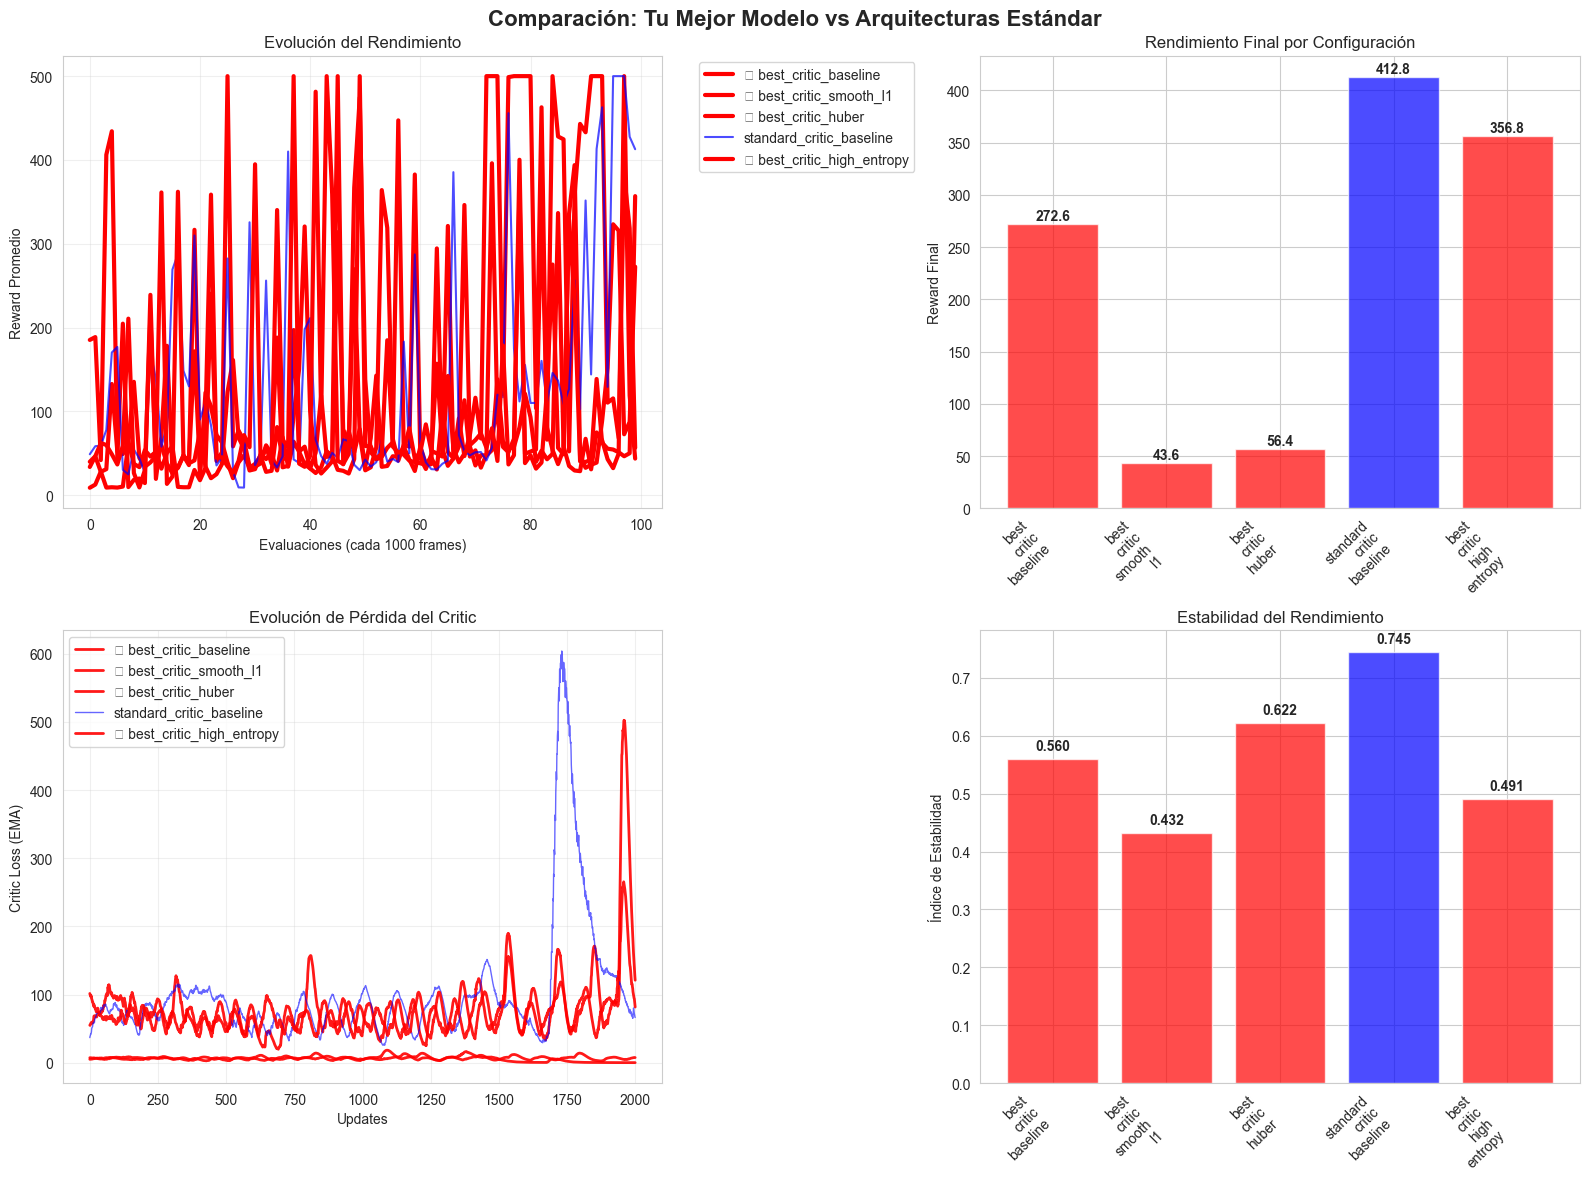

In [16]:
# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparación: Tu Mejor Modelo vs Arquitecturas Estándar', fontsize=16, fontweight='bold')

# 1. Evolución del rendimiento
ax1 = axes[0, 0]
for name, result in results.items():
    color = 'red' if result['uses_best_critic'] else 'blue'
    linewidth = 3 if result['uses_best_critic'] else 1.5
    alpha = 1.0 if result['uses_best_critic'] else 0.7
    label = f"★ {name}" if result['uses_best_critic'] else name

    ax1.plot(result['metrics'].eval_rewards_mean, label=label,
            color=color, linewidth=linewidth, alpha=alpha)

ax1.set_xlabel('Evaluaciones (cada 1000 frames)')
ax1.set_ylabel('Reward Promedio')
ax1.set_title('Evolución del Rendimiento')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. Rendimiento final
ax2 = axes[0, 1]
names = list(results.keys())
final_scores = [results[name]['final_performance'] for name in names]
colors = ['red' if results[name]['uses_best_critic'] else 'blue' for name in names]

bars = ax2.bar(range(len(names)), final_scores, color=colors, alpha=0.7)
ax2.set_ylabel('Reward Final')
ax2.set_title('Rendimiento Final por Configuración')
ax2.set_xticks(range(len(names)))
ax2.set_xticklabels([n.replace('_', '\n') for n in names], rotation=45, ha='right')

for i, (bar, score) in enumerate(zip(bars, final_scores)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{score:.1f}', ha='center', va='bottom', fontweight='bold')

# 3. Pérdida del Critic
ax3 = axes[1, 0]
for name, result in results.items():
    color = 'red' if result['uses_best_critic'] else 'blue'
    linewidth = 2 if result['uses_best_critic'] else 1
    alpha = 0.9 if result['uses_best_critic'] else 0.6
    label = f"★ {name}" if result['uses_best_critic'] else name

    ax3.plot(ema(result['metrics'].critic_losses, 0.05), label=label,
            color=color, linewidth=linewidth, alpha=alpha)

ax3.set_xlabel('Updates')
ax3.set_ylabel('Critic Loss (EMA)')
ax3.set_title('Evolución de Pérdida del Critic')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Análisis de estabilidad
ax4 = axes[1, 1]
stability_scores = []
stability_labels = []

for name, result in results.items():
    if len(result['metrics'].eval_rewards_mean) > 10:
        recent_rewards = result['metrics'].eval_rewards_mean[-10:]
        cv = np.std(recent_rewards) / (np.mean(recent_rewards) + 1e-8)
        stability = 1 / (1 + cv)

        stability_scores.append(stability)
        stability_labels.append(name)

if stability_scores:
    colors = ['red' if results[name]['uses_best_critic'] else 'blue' for name in stability_labels]
    bars = ax4.bar(range(len(stability_labels)), stability_scores, color=colors, alpha=0.7)
    ax4.set_ylabel('Índice de Estabilidad')
    ax4.set_title('Estabilidad del Rendimiento')
    ax4.set_xticks(range(len(stability_labels)))
    ax4.set_xticklabels([n.replace('_', '\n') for n in stability_labels], rotation=45, ha='right')

    for bar, score in zip(bars, stability_scores):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [17]:
best_models = [name for name, result in results.items() if result['uses_best_critic']]
standard_models = [name for name, result in results.items() if not result['uses_best_critic']]

In [18]:
best_performance = np.mean([results[name]['final_performance'] for name in best_models])
standard_performance = np.mean([results[name]['final_performance'] for name in standard_models])
improvement = ((best_performance - standard_performance) / standard_performance) * 100

print(f"Rendimiento promedio con TU MEJOR MODELO: {best_performance:.2f}")
print(f"Rendimiento promedio con Critic estándar: {standard_performance:.2f}")
print(f"Mejora obtenida: {improvement:+.1f}%")

Rendimiento promedio con TU MEJOR MODELO: 182.35
Rendimiento promedio con Critic estándar: 412.80
Mejora obtenida: -55.8%
